In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
import joblib, json, matplotlib.pyplot as plt, seaborn as sns

import numpy as np, pandas as pd, joblib
from pathlib import Path
from sklearn.preprocessing   import MultiLabelBinarizer
from sklearn.multiclass      import OneVsRestClassifier

from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble      import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier


RANDOM = 42

# Preprocessing

In [5]:
train_df = pd.read_json("../data/craft-ml-data-train.jsonl", lines=True)
# train_df = train_df.explode("labels")
X_train = train_df["text"]
y_train = train_df["labels"].str[0]

test_df = pd.read_json("../data/craft-ml-data-test.jsonl", lines=True)
# test_df = test_df.explode("labels")
X_test = test_df["text"]
y_test = test_df["labels"].str[0]

# Single Class Baseline

I want to see how hard this is under a one label process then move to two labels

In [6]:
word_tfidf = TfidfVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=2,
    ngram_range=(1,2),          # unigrams + bigrams
    dtype=np.float32
)

char_tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=2,
    dtype=np.float32
)

In [7]:
def make_pipeline(vec, clf, k_best=None):
    steps = [("vec", vec)]
    steps += [("clf", clf)]
    return Pipeline(steps)


In [8]:
baselines = {
    "LogReg_word" : make_pipeline(
        word_tfidf,
        LogisticRegression(max_iter=1000, class_weight="balanced", C=2.0)
    ),
    "SVM_word"    : make_pipeline(
        word_tfidf,
        LinearSVC(C=1.0, class_weight="balanced")
    ),
    "CompNB_word" : make_pipeline(
        word_tfidf,
        ComplementNB()
    ),
    # hybrid word+char union
    "LogReg_word+char" : make_pipeline(
        FeatureUnion([("word", word_tfidf), ("char", char_tfidf)]),
        LogisticRegression(max_iter=1000, class_weight="balanced", C=2.0)
    ),
}

for name, model in baselines.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(accuracy_score(y_test, y_pred))
    # persist if useful
    # joblib.dump(model, f"models/{name}.pkl")



=== LogReg_word ===
0.6792452830188679

=== SVM_word ===
0.660377358490566

=== CompNB_word ===
0.6226415094339622

=== LogReg_word+char ===
0.6415094339622641


### Takeaways
- Performance on single class isnt that good from simple baseline models
- Logistic Regression on words only tfidf performs best. pefromance worsens when adding in characters. 

# Multiclass Baseline

In [9]:
X_train, y_train_r = train_df["text"].values, train_df["labels"].values

X_test, y_test_r = test_df["text"].values, test_df["labels"].values

mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train_r)
y_test = mlb.transform(y_test_r)
y_train.shape, y_test.shape
y_train[0], y_test[0]

(array([0, 0, 0, 0, 1, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 1, 0]))

In [13]:
dense_vec = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        max_df=0.9,
        min_df=2,
        ngram_range=(1,2),
        dtype=np.float32
    )),
    ("svd", TruncatedSVD(n_components=100, random_state=RANDOM))
])

OVR_LogReg       micro-F1: 0.519  macro-F1: 0.512  subset-Acc: 0.302


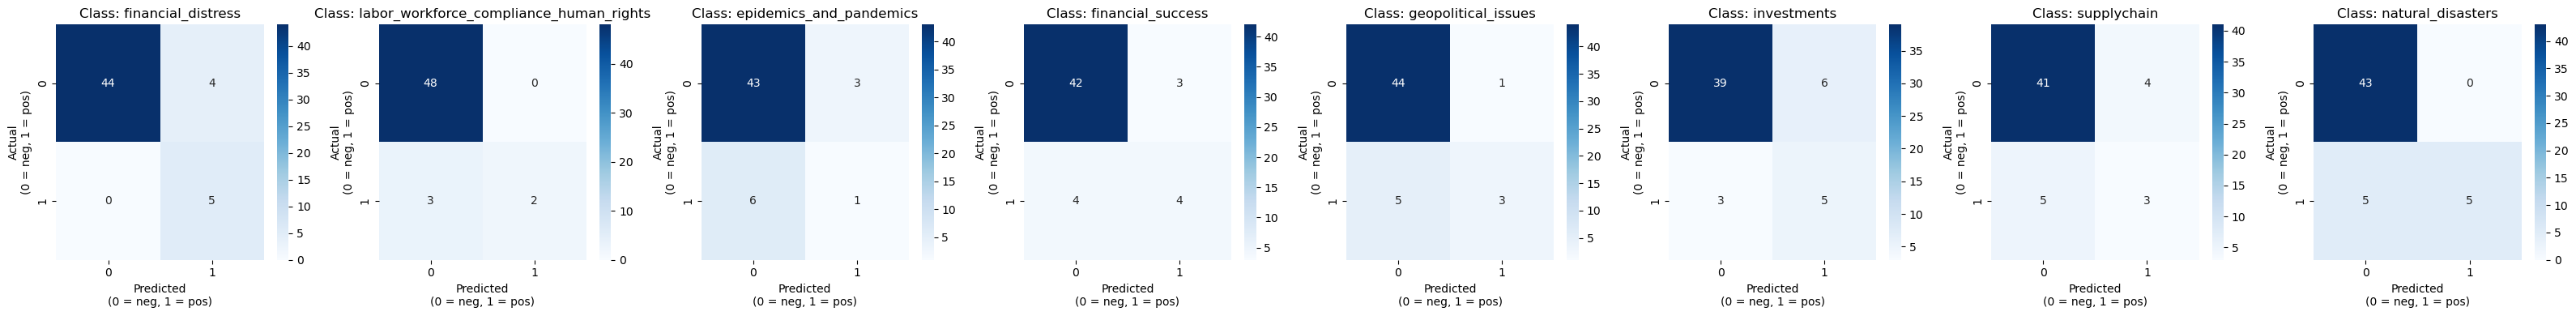

OVR_LinearSVC    micro-F1: 0.520  macro-F1: 0.514  subset-Acc: 0.340


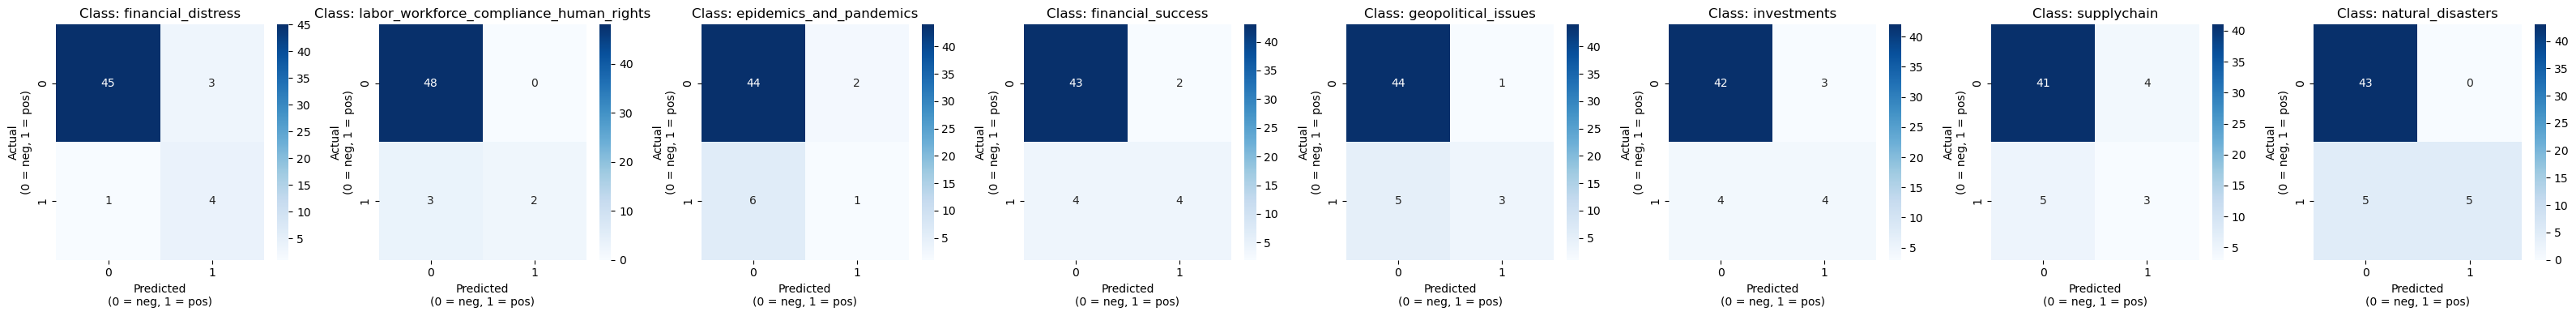

OVR_RF_500       micro-F1: 0.386  macro-F1: 0.371  subset-Acc: 0.208


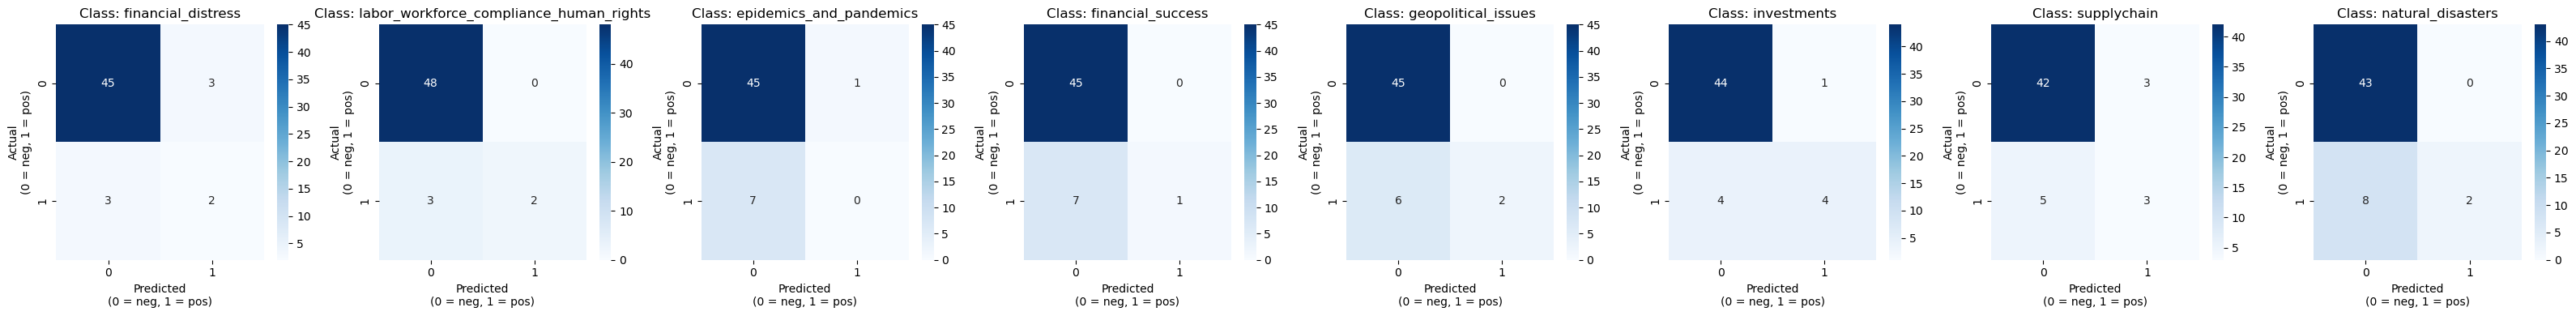

OVR_XGB          micro-F1: 0.414  macro-F1: 0.399  subset-Acc: 0.283


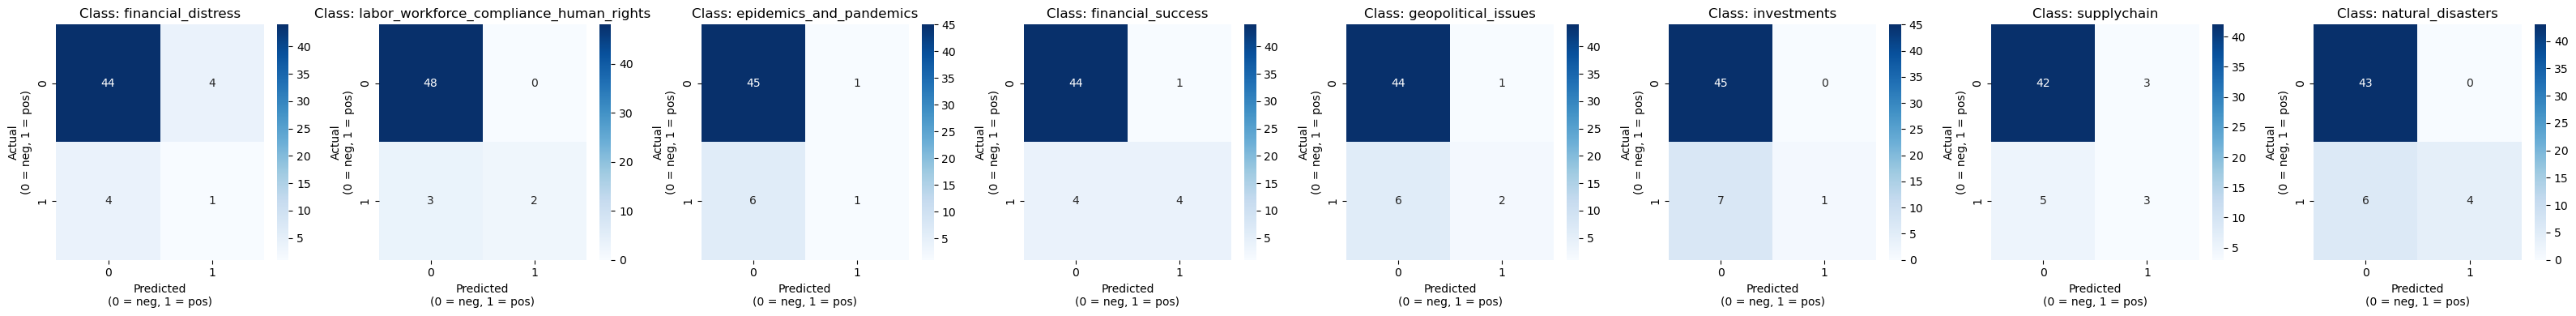

In [ ]:
multi_clfs = {
    # linear models
    "OVR_LogReg"      : LogisticRegression(max_iter=1000, C=2.0, class_weight="balanced", random_state=RANDOM),
    "OVR_LinearSVC"   : LinearSVC(C=1.0, class_weight="balanced", random_state=RANDOM),

    "OVR_RF_500"      : RandomForestClassifier(),
    "OVR_XGB"      : XGBClassifier()
}

for name, base_clf in multi_clfs.items():
    pipe = Pipeline([
        ("vec", dense_vec),
        ("clf", OneVsRestClassifier(base_clf, n_jobs=-1))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    micro  = f1_score(y_test, y_pred, average="micro")
    macro  = f1_score(y_test, y_pred, average="macro")
    subset = accuracy_score(y_test, y_pred)

    print(f"{name:15s}  micro-F1: {micro:.3f}  macro-F1: {macro:.3f}  subset-Acc: {subset:.3f}")

    actual_counts = np.array(y_test).sum(axis=0)
    pred_counts = np.array(y_pred).sum(axis=0)
    labels = mlb.classes_

    # 2. Confusion matrices for top 5 most frequent labels
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    top_idxs = np.argsort(actual_counts)[-10:]  # indices of 5 largest classes

    fig, axes = plt.subplots(1, len(top_idxs), figsize=(4*len(top_idxs), 4))
    for ax, idx in zip(axes, top_idxs):
        sns.heatmap(mcm[idx], annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f"Class: {labels[idx]}")
        ax.set_xlabel('Predicted\n(0 = neg, 1 = pos)')
        ax.set_ylabel('Actual\n(0 = neg, 1 = pos)')
    plt.tight_layout()
    plt.show()